## CIFAR 10 project
The CIFAR-10 dataset is a popular dataset used for benchmarking various vision algorithms. The baseline for most vision problems start with MNIST dataset, and then move onto slightly more complicated tasks such as CIFAR-10 and CIFAR-100. The problem at hand is a multi-class classification problem (10 classes) with each data point being a 32 $\times$ 32 RGB image and each image corresponding to one of the below categories in the image. 
![CIFAR Classes](Data/Img1.png)
For more details about the dataset refer to [CIFAR project page](https://www.cs.toronto.edu/~kriz/cifar.html) 

## Test for **CUDA**

Check if your hardware supports GPU so as to accelerate the training process. CUDA is a parallel computing platform that utilize GPUs for CUDA tensors 

In [118]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available! Training on GPU')
else:
    print('CUDA is not available! Training on CPU')

CUDA is not available! Training on CPU


## Import the Data

The dataset is available on the official project page [CIFAR project page](https://www.cs.toronto.edu/~kriz/cifar.html). However, this dataset is also available on torchvision datasets as it is used frequently for experimentation. We'll use the dataset available in torchvision.

In [128]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 128
valid_size = 0.2

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Data Visualization

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

def imgshow(image):
    image = image / 2 + 0.5
    plt.imshow(np.transpose(image, (1, 2, 0)))

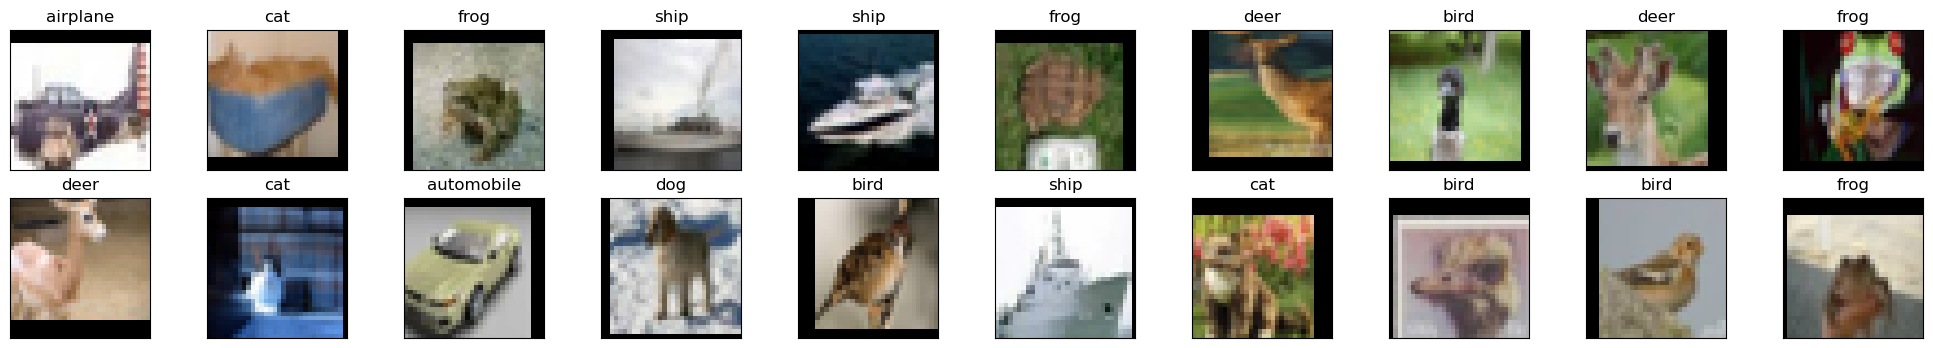

In [130]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imgshow(images[idx])
    ax.set_title(classes[labels[idx]])

Let us take a closer look at images by normalizing the RGB channels as three seperate grayscale intensity images.

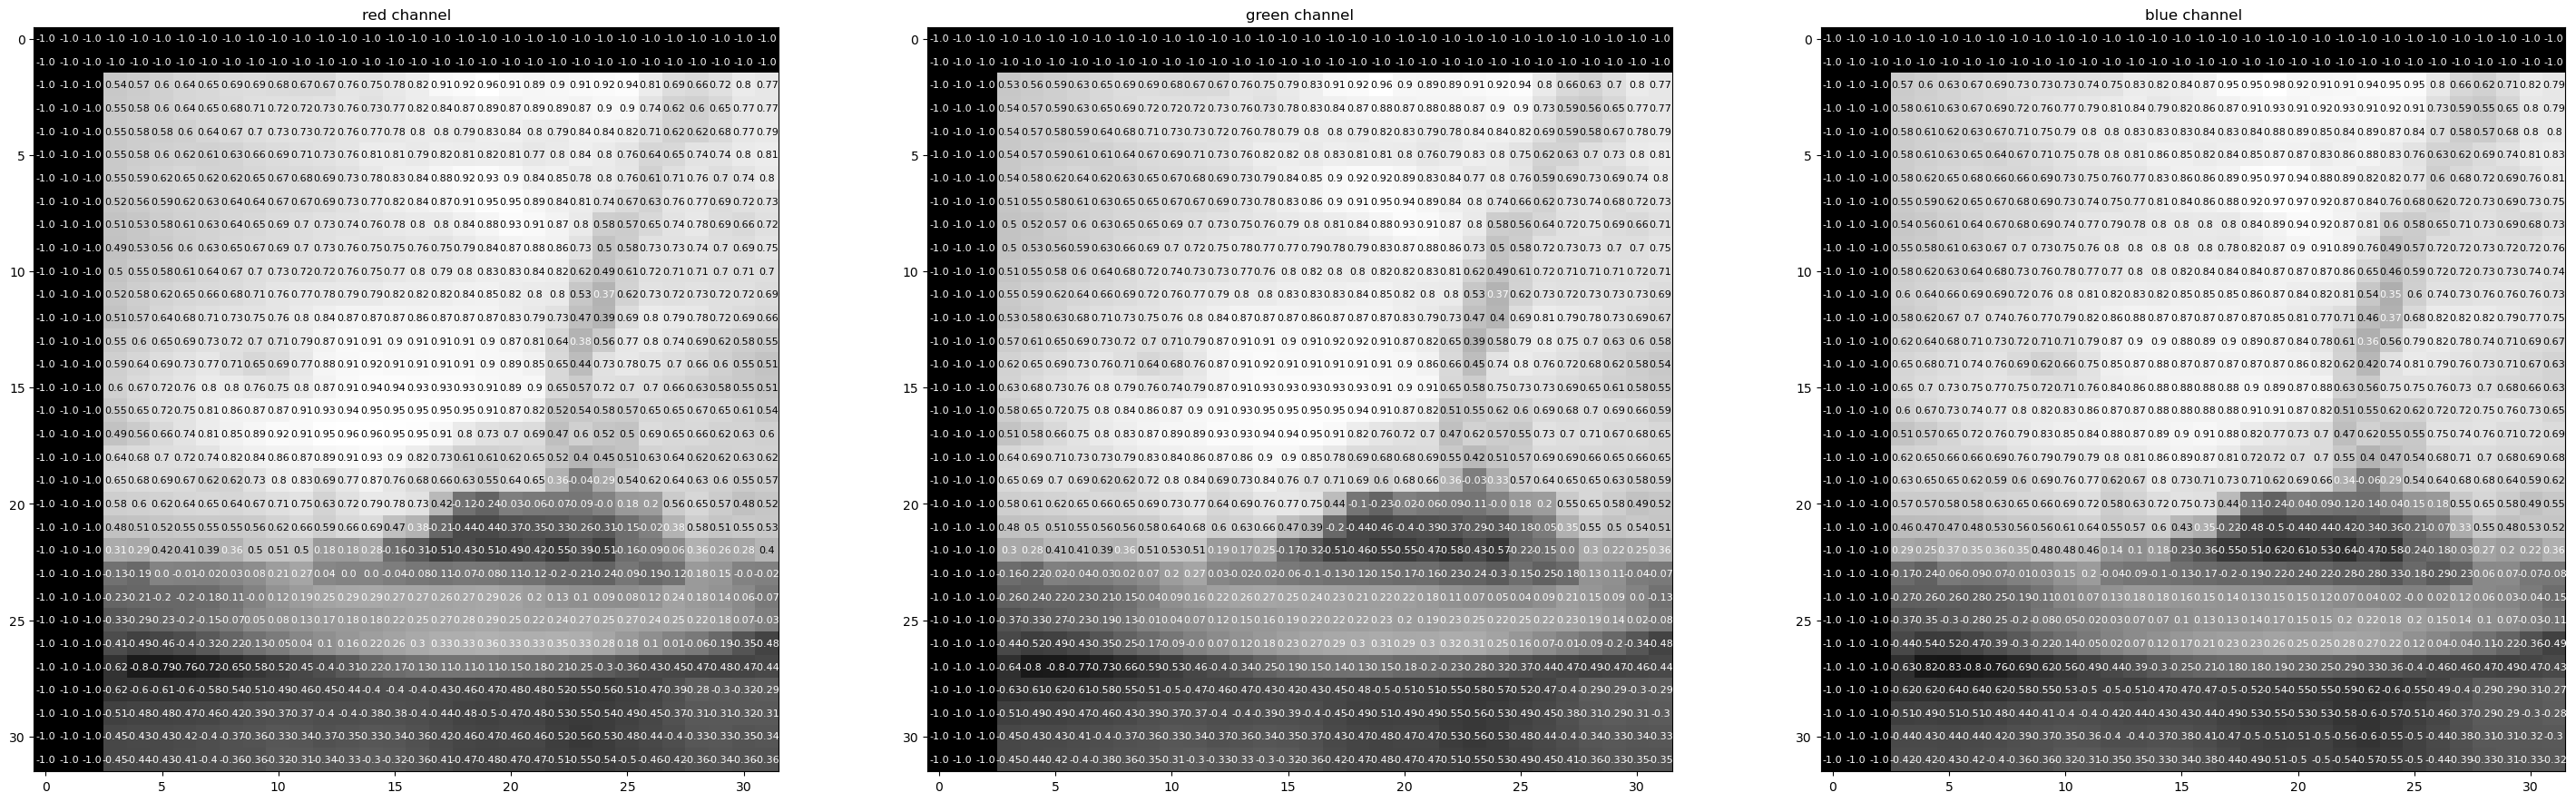

In [131]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

Let us define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, we'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and we've been given starter code with one convolutional and one maxpoolin

![](Data/Img2.png)
k behavior.

The more convolutional layers we include, the more complex patterns in color and shape a model can detect. It's suggested that our final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining our own models. We may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [132]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = self.dropout2(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how our model converges to a small erroime.

In [133]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [144]:
# number of epochs to train the model
n_epochs = 40

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.671727 	Validation Loss: 0.633683
Validation loss decreased (inf --> 0.633683).  Saving model ...
Epoch: 2 	Training Loss: 0.669825 	Validation Loss: 0.628317
Validation loss decreased (0.633683 --> 0.628317).  Saving model ...
Epoch: 3 	Training Loss: 0.666032 	Validation Loss: 0.605979
Validation loss decreased (0.628317 --> 0.605979).  Saving model ...
Epoch: 4 	Training Loss: 0.656763 	Validation Loss: 0.600397
Validation loss decreased (0.605979 --> 0.600397).  Saving model ...
Epoch: 5 	Training Loss: 0.652456 	Validation Loss: 0.588737
Validation loss decreased (0.600397 --> 0.588737).  Saving model ...
Epoch: 6 	Training Loss: 0.652717 	Validation Loss: 0.597975
Epoch: 7 	Training Loss: 0.646309 	Validation Loss: 0.607838
Epoch: 8 	Training Loss: 0.641585 	Validation Loss: 0.577083
Validation loss decreased (0.588737 --> 0.577083).  Saving model ...
Epoch: 9 	Training Loss: 0.638172 	Validation Loss: 0.594828
Epoch: 10 	Training Loss: 0.631338 	Valida

##  Load the Model with the Lowest Validation Loss

In [145]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

## Test the Trained Network

Testing the trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try our best!) accuracy on these test images.

In [146]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.491161

Test Accuracy of airplane: 88% (889/1000)
Test Accuracy of automobile: 92% (923/1000)
Test Accuracy of  bird: 72% (724/1000)
Test Accuracy of   cat: 61% (613/1000)
Test Accuracy of  deer: 82% (826/1000)
Test Accuracy of   dog: 80% (809/1000)
Test Accuracy of  frog: 88% (882/1000)
Test Accuracy of horse: 84% (848/1000)
Test Accuracy of  ship: 91% (914/1000)
Test Accuracy of truck: 89% (890/1000)

Test Accuracy (Overall): 83% (8318/10000)


### Visualize Sample Test Results

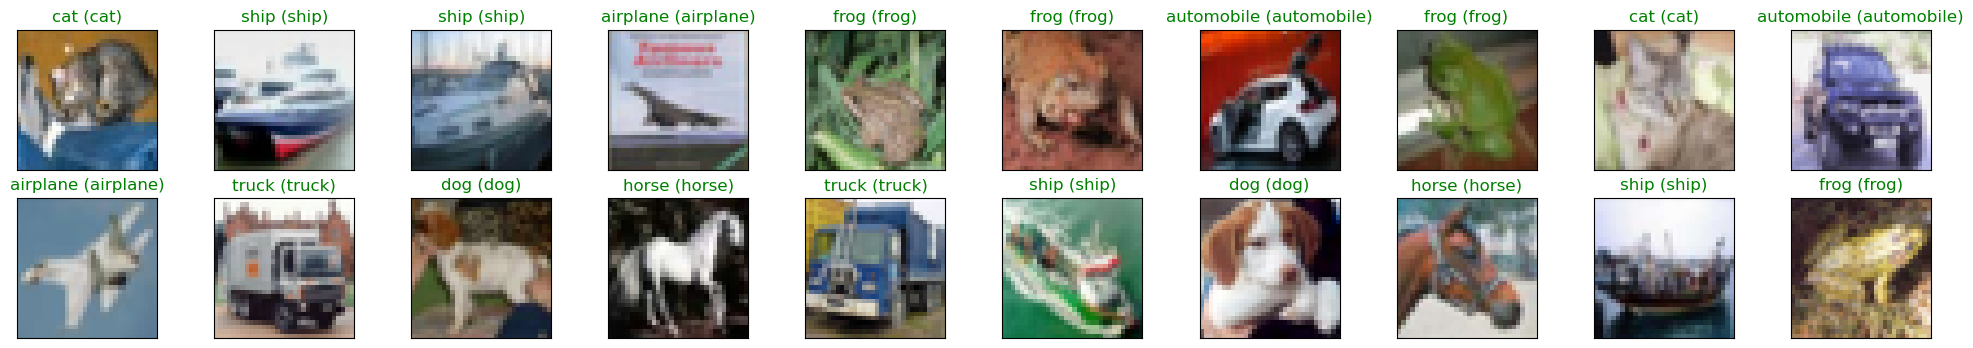

In [148]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imgshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [157]:
torch.save(model, 'model.pth')